In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import math
import logging
from pathlib import Path

import numpy as np
import scipy as sp
import sklearn
from sklearn.model_selection import GridSearchCV 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# import missingno as msgo

from category_encoders.target_encoder import TargetEncoder
from category_encoders.one_hot import OneHotEncoder

from sklearn.metrics import (classification_report, plot_confusion_matrix, plot_precision_recall_curve, 
                             plot_roc_curve, precision_score, recall_score, f1_score)
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (10, 6)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)


In [3]:
from src.eda_utils import insert_note
from src.modeling_utils import plot_train_test_metrics
from src.preprocess import preprocess

In [4]:
raw = pd.read_csv('data/dados.csv', sep=';')
raw.head()                  

/home/jrcunha/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (24) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Dia semana agendamento,Ano agendamento,Mes agendamento,Hora agendamento,Dia mes agendamento,Dia semana atendimento,Ano atendimento,Mes atendimento,Hora atendimento,Dia mes atendimento,Secao,Medico preferencial,Renda Provavel,MicroArea,Diretoria,Cod convenio,Codigo exame,Idade,Tempo medio de agendamento,Unidade,Bairro,Feminino,No Show,Unnamed: 23,Legenda
0,6,2019,8,8,18,3,2019,8,15,15,110,0,1028823,377,7,115,465530,39,2,VILLA LOBOS,4218,1,0,NaN,Show = 0
1,2,2019,11,7,6,0,2019,11,13,4,110,0,1028823,377,7,115,465530,39,1,VILLA LOBOS,4218,1,1,NaN,No Show = 1
2,5,2019,8,8,31,3,2019,8,15,15,36,0,1028823,377,7,115,465530,39,15,ITAIM,4218,1,0,NaN,NaN
3,4,2019,9,11,27,4,2019,9,8,27,110,1,489594,767,7,115,465530,49,0,HIGIENÓPOLIS,2169,1,0,NaN,NaN
4,4,2019,10,11,11,1,2019,10,17,1,110,0,31829,568,7,115,7244510,33,9,ALPHAVILLE,9638,1,0,NaN,NaN


In [5]:
df = preprocess(raw, rm_outlier=True)

/home/jrcunha/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/home/jrcunha/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


removing outliers
dias_ate_atendimento
tempo_medio_de_agendamento
renda_provavel
idade


In [6]:
df.head()

,dias_ate_atendimento,tempo_medio_de_agendamento,renda_provavel,idade,feminino,medico_preferencial,diretoria,dia_semana_agendamento,dia_semana_atendimento,hora_agendamento,hora_atendimento,secao,microarea,cod_convenio,codigo_exame,unidade,bairro,no_show
0,3,2,1028.823,39,1,0,7,6,3,8,15,110,-100,115,465530,VILLA LOBOS,-100,0
1,2,1,1028.823,39,1,0,7,2,0,7,13,110,-100,115,465530,VILLA LOBOS,-100,1
4,10,9,31.829,33,1,0,7,4,1,11,17,110,-100,115,7244510,ALPHAVILLE,-100,0
10,1,1,31.829,33,1,0,7,1,0,17,10,96,-100,115,7244510,HIGIENÓPOLIS,-100,0
11,6,5,1594.189,44,1,0,7,1,2,10,13,110,3,115,465530,PARAÍSO,56,0


In [7]:
df['hora_atendimento'] = df['hora_atendimento'].apply(lambda x: -x**2)
df['hora_agendamento'] = df['hora_agendamento'].apply(lambda x: x**2)

In [8]:
df.columns

Index(['dias_ate_atendimento', 'tempo_medio_de_agendamento', 'renda_provavel',
       'idade', 'feminino', 'medico_preferencial', 'diretoria',
       'dia_semana_agendamento', 'dia_semana_atendimento', 'hora_agendamento',
       'hora_atendimento', 'secao', 'microarea', 'cod_convenio',
       'codigo_exame', 'unidade', 'bairro', 'no_show'],
      dtype='object')

In [9]:
df.head()

,dias_ate_atendimento,tempo_medio_de_agendamento,renda_provavel,idade,feminino,medico_preferencial,diretoria,dia_semana_agendamento,dia_semana_atendimento,hora_agendamento,hora_atendimento,secao,microarea,cod_convenio,codigo_exame,unidade,bairro,no_show
0,3,2,1028.823,39,1,0,7,6,3,64,-225,110,-100,115,465530,VILLA LOBOS,-100,0
1,2,1,1028.823,39,1,0,7,2,0,49,-169,110,-100,115,465530,VILLA LOBOS,-100,1
4,10,9,31.829,33,1,0,7,4,1,121,-289,110,-100,115,7244510,ALPHAVILLE,-100,0
10,1,1,31.829,33,1,0,7,1,0,289,-100,96,-100,115,7244510,HIGIENÓPOLIS,-100,0
11,6,5,1594.189,44,1,0,7,1,2,100,-169,110,3,115,465530,PARAÍSO,56,0


In [10]:
to_encode = ['dia_semana_agendamento',  'dia_semana_atendimento',
             'secao', 'unidade', 'microarea', 'codigo_exame', 'bairro',
             'cod_convenio']

hot_encode = ['feminino', 'medico_preferencial', 'diretoria']

In [11]:
X = df.drop('no_show', axis=1)
y = df['no_show']

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=142)

In [14]:
encoder = TargetEncoder(cols=to_encode)
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

/home/jrcunha/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [15]:
oh_encoder = OneHotEncoder(cols=hot_encode,
                          use_cat_names=True,
                          handle_missing='missing')


X_train = oh_encoder.fit_transform(X_train)
X_test = oh_encoder.transform(X_test)

/home/jrcunha/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [16]:
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [17]:
final_columns = ['dias_ate_atendimento', 'tempo_medio_de_agendamento', 'renda_provavel', 'idade', 
                 'feminino_1.0', 'medico_preferencial_1.0', 'diretoria_6.0',
                 'dia_semana_agendamento', 'dia_semana_atendimento',
                 'secao', 'microarea','cod_convenio', 'codigo_exame', 'unidade', 'bairro',
                 'hora_atendimento', 'hora_agendamento']

X_train = X_train[final_columns]
X_test = X_test[final_columns]

In [18]:
X_train.head()

,dias_ate_atendimento,tempo_medio_de_agendamento,renda_provavel,idade,feminino_1.0,medico_preferencial_1.0,diretoria_6.0,dia_semana_agendamento,dia_semana_atendimento,secao,microarea,cod_convenio,codigo_exame,unidade,bairro,hora_atendimento,hora_agendamento
0,0.750000,0.727273,0.036439,0.293103,0.0,0.0,0.0,0.100287,0.657536,0.271916,0.439053,0.454291,0.491452,0.391418,0.448343,0.424837,0.077381
1,0.333333,0.272727,0.519590,0.879310,1.0,0.0,0.0,0.215238,0.480338,0.153420,0.470132,0.488715,0.614970,0.457967,0.612912,0.790850,0.148810
2,0.416667,0.454545,0.044647,0.431034,1.0,0.0,0.0,0.531690,0.657536,0.124939,0.020880,0.569717,0.614039,0.236222,0.547936,0.790850,0.236111
3,0.583333,0.545455,0.854399,0.982759,1.0,1.0,0.0,0.180633,0.480338,0.133228,0.237432,0.720591,0.855005,0.413680,0.505655,0.877996,0.111111
4,0.083333,0.000000,0.143970,0.344828,1.0,0.0,0.0,1.000000,0.885096,0.037972,0.439074,0.379597,0.525726,0.413680,0.547936,0.564270,0.190476


In [19]:
X_train.shape, y_train.shape

((120144, 17), (120144,))

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
seed = 142
params = {'C': 1e-4, 
          'class_weight': 'balanced',
          'max_iter': 1000,
          'multi_class': 'auto',
          'n_jobs': -1,
          'penalty': 'l2', 
          'random_state': seed,
          'solver': 'lbfgs'} 

lr_model = LogisticRegression(**params)

In [22]:
lr_model.fit(X_train, y_train)

LogisticRegression(C=0.0001, class_weight='balanced', max_iter=1000, n_jobs=-1,
                   random_state=142)

/home/jrcunha/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/jrcunha/anaconda3/lib/python3.8/site-packages/yellowbrick/model_selection/importances.py:189: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


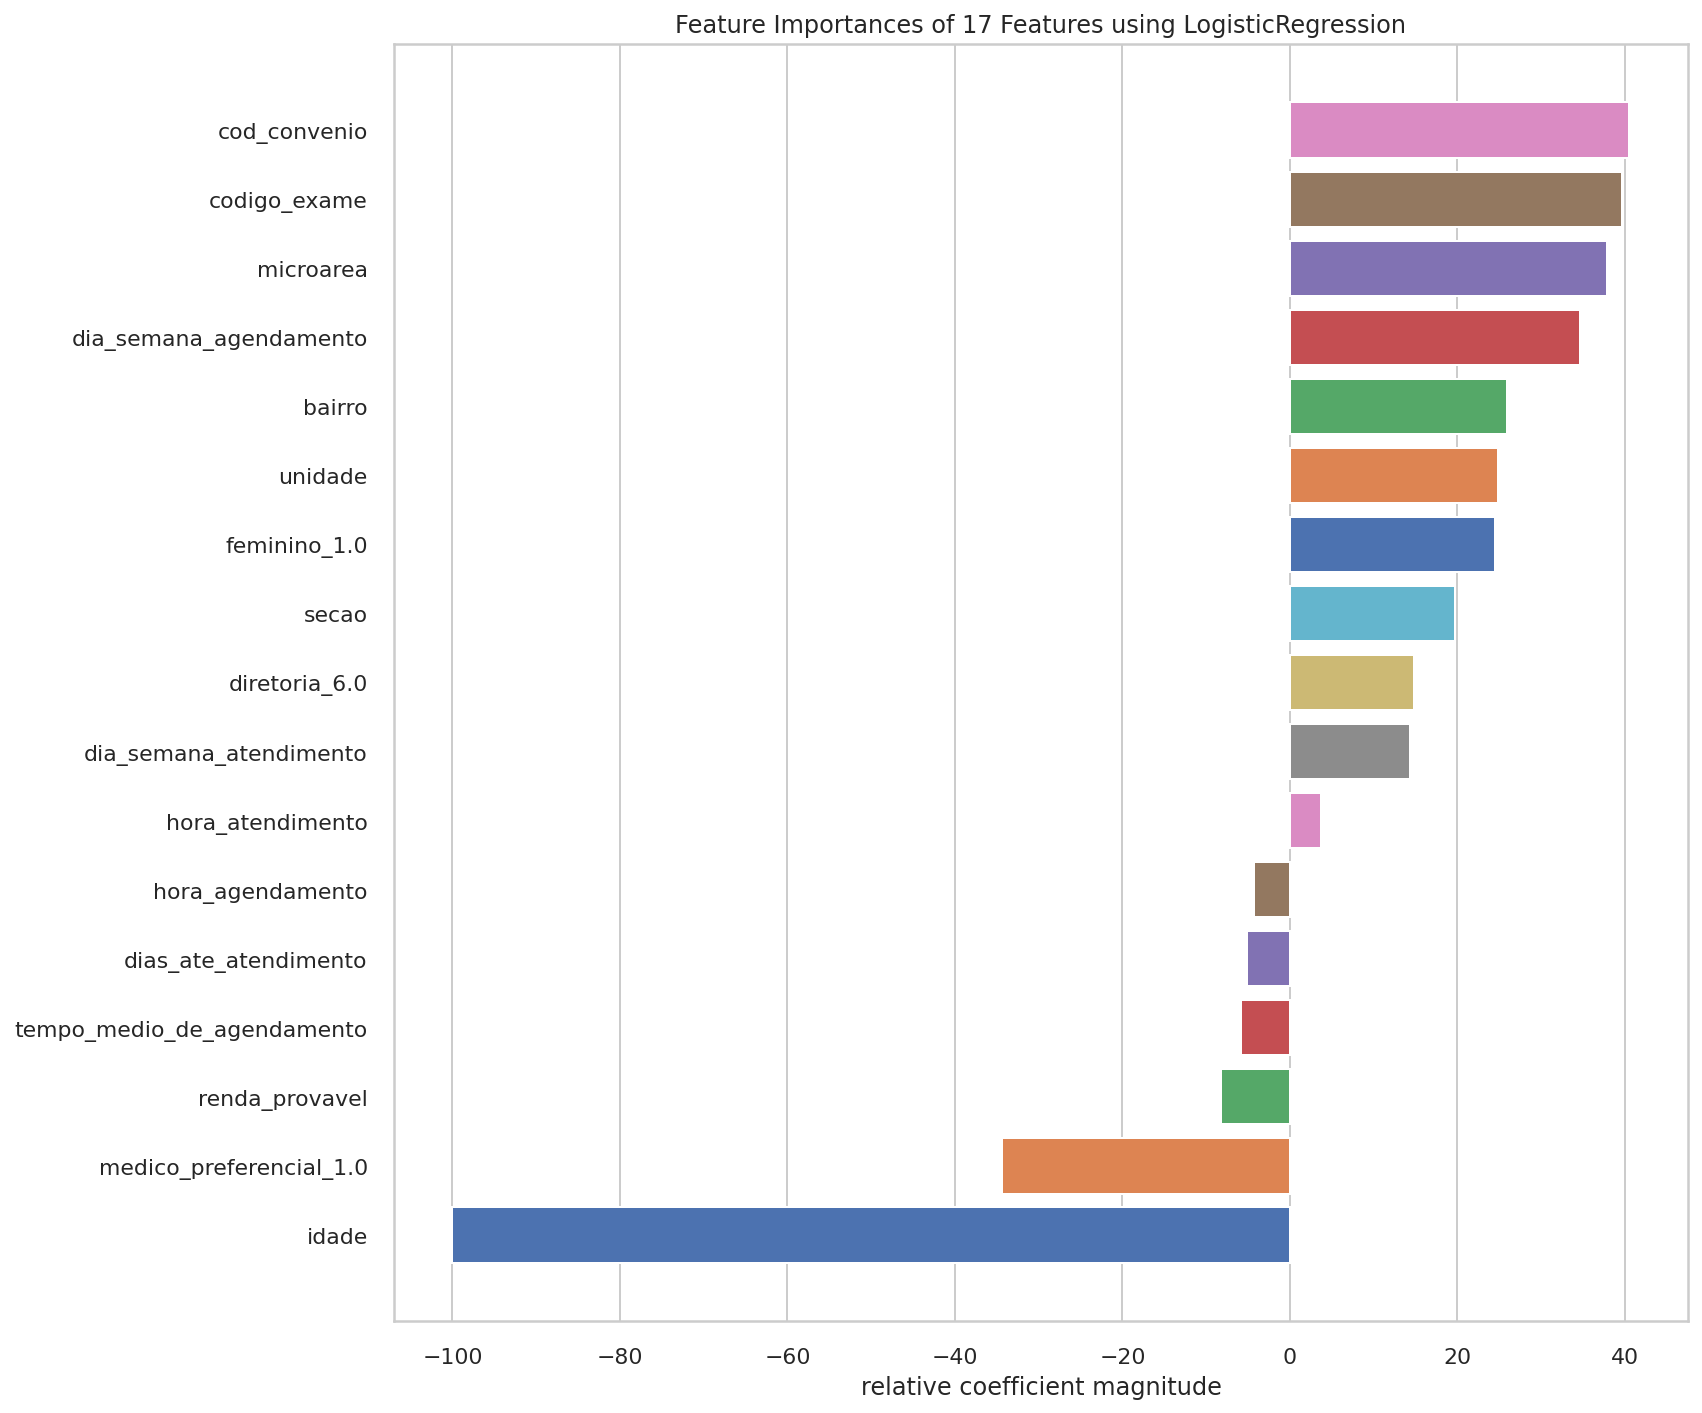

In [23]:
from yellowbrick.model_selection import FeatureImportances

plt.figure(figsize=(12,10))

viz = FeatureImportances(lr_model)
viz.fit(X_train, y_train)
viz.show();

### Metrics

In [24]:
y_pred = lr_model.predict(X_test)
y_score = lr_model.predict_proba(X_test)[:,1]

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.58      0.71     26172
           1       0.18      0.61      0.27      3864

    accuracy                           0.58     30036
   macro avg       0.54      0.60      0.49     30036
weighted avg       0.82      0.58      0.65     30036



In [26]:
print("precision: ", precision_score(y_test, y_pred))
print("recall: ", recall_score(y_test, y_pred))
print("f1: ", f1_score(y_test, y_pred))

precision:  0.17640056543411947
recall:  0.6136128364389234
f1:  0.27402484830973706


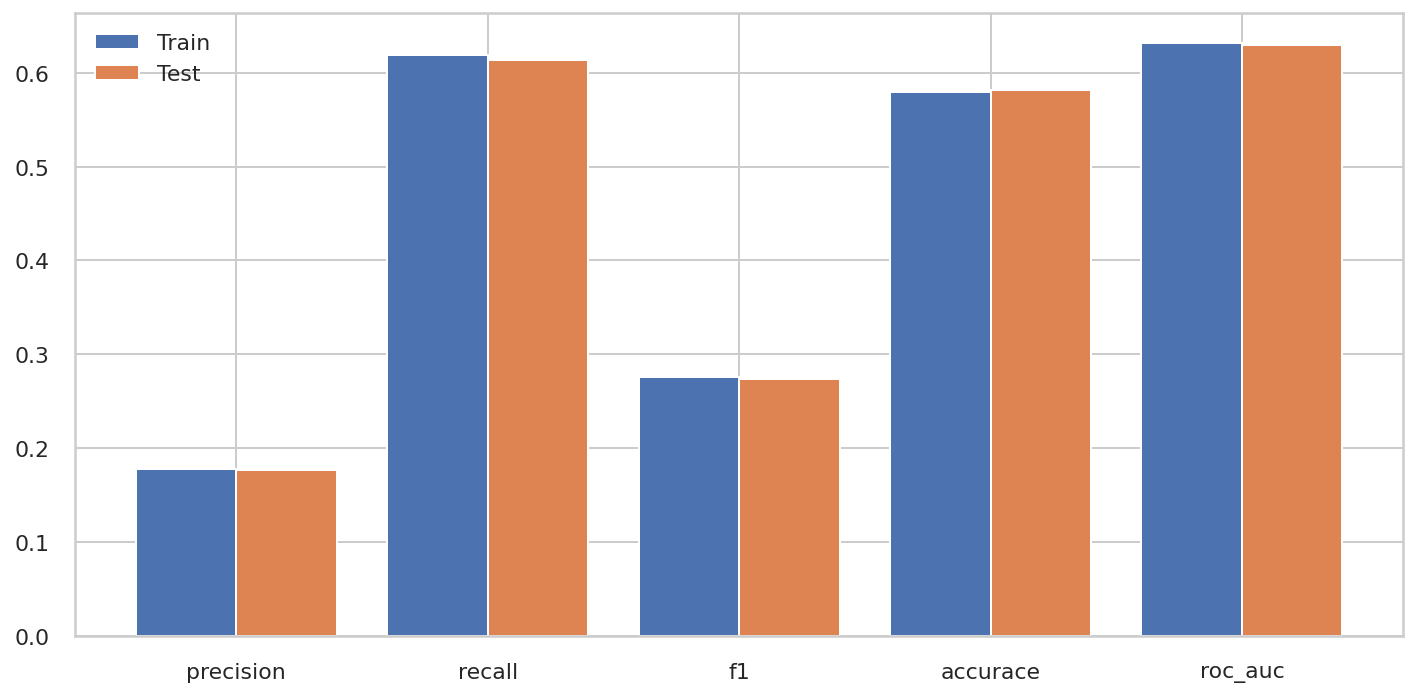

In [27]:
plot_train_test_metrics(lr_model, X_train, y_train, X_test, y_test)

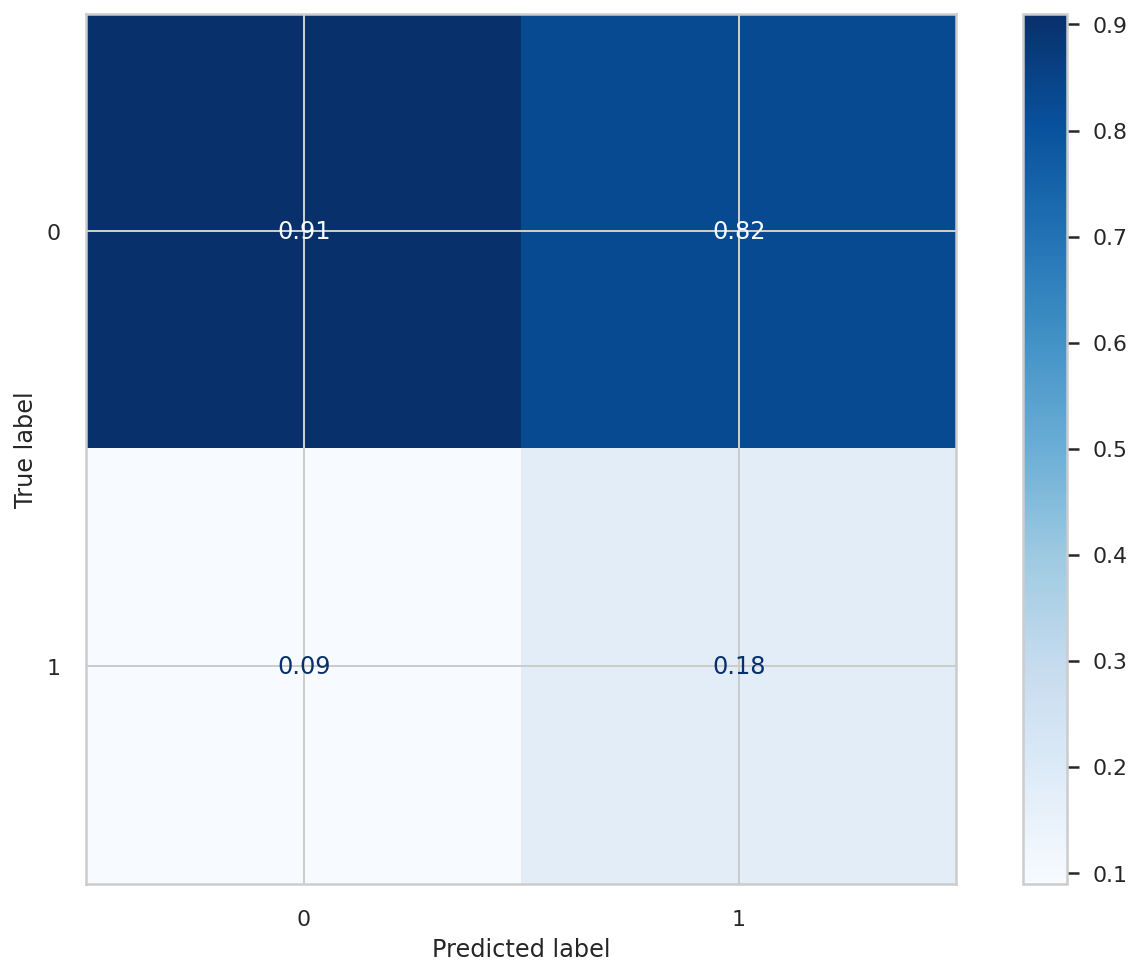

In [28]:
plot_confusion_matrix(lr_model, X_test, y_test, normalize='pred',  cmap='Blues');

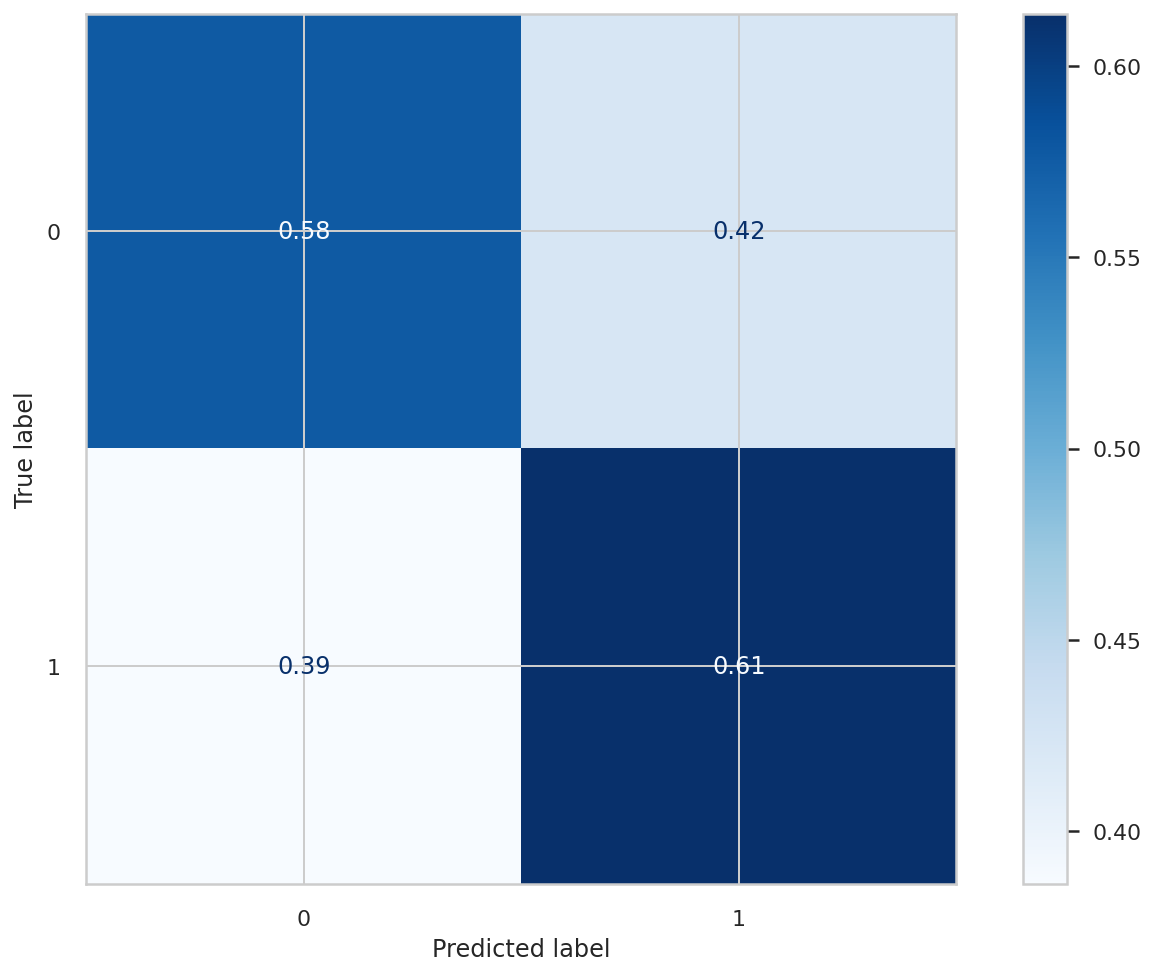

In [29]:
plot_confusion_matrix(lr_model, X_test, y_test, normalize='true',  cmap='Blues');

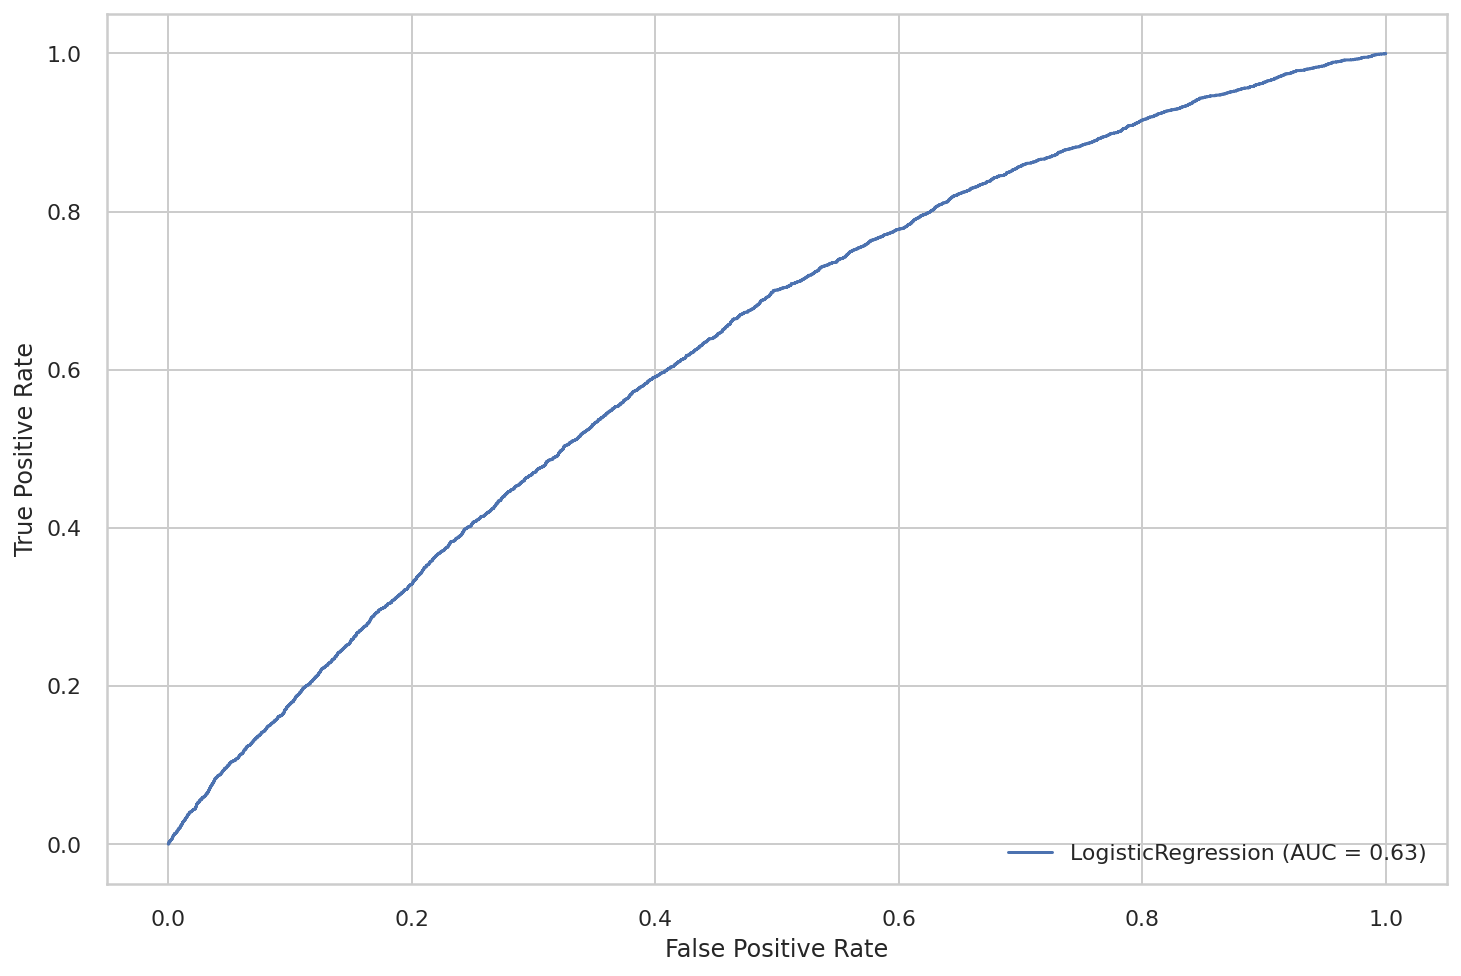

In [30]:
plot_roc_curve(lr_model, X_test, y_test);

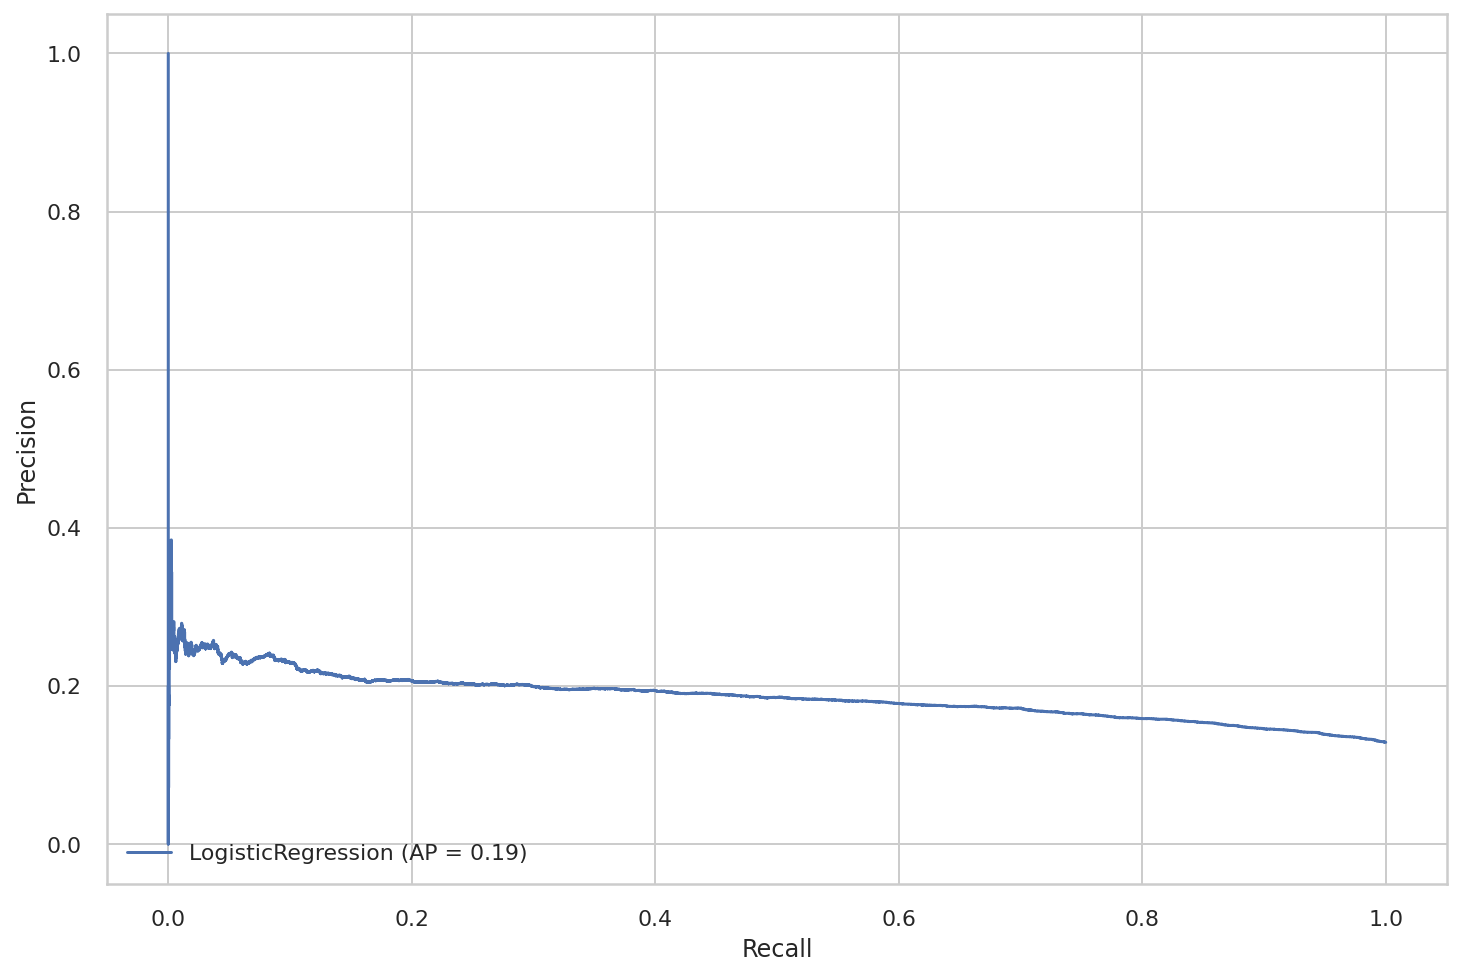

In [31]:
plot_precision_recall_curve(lr_model, X_test, y_test);

In [32]:
result = pd.DataFrame()
result["y_pred"] = y_pred
result["y_test"] = y_test.values
result["y_score"] = y_score

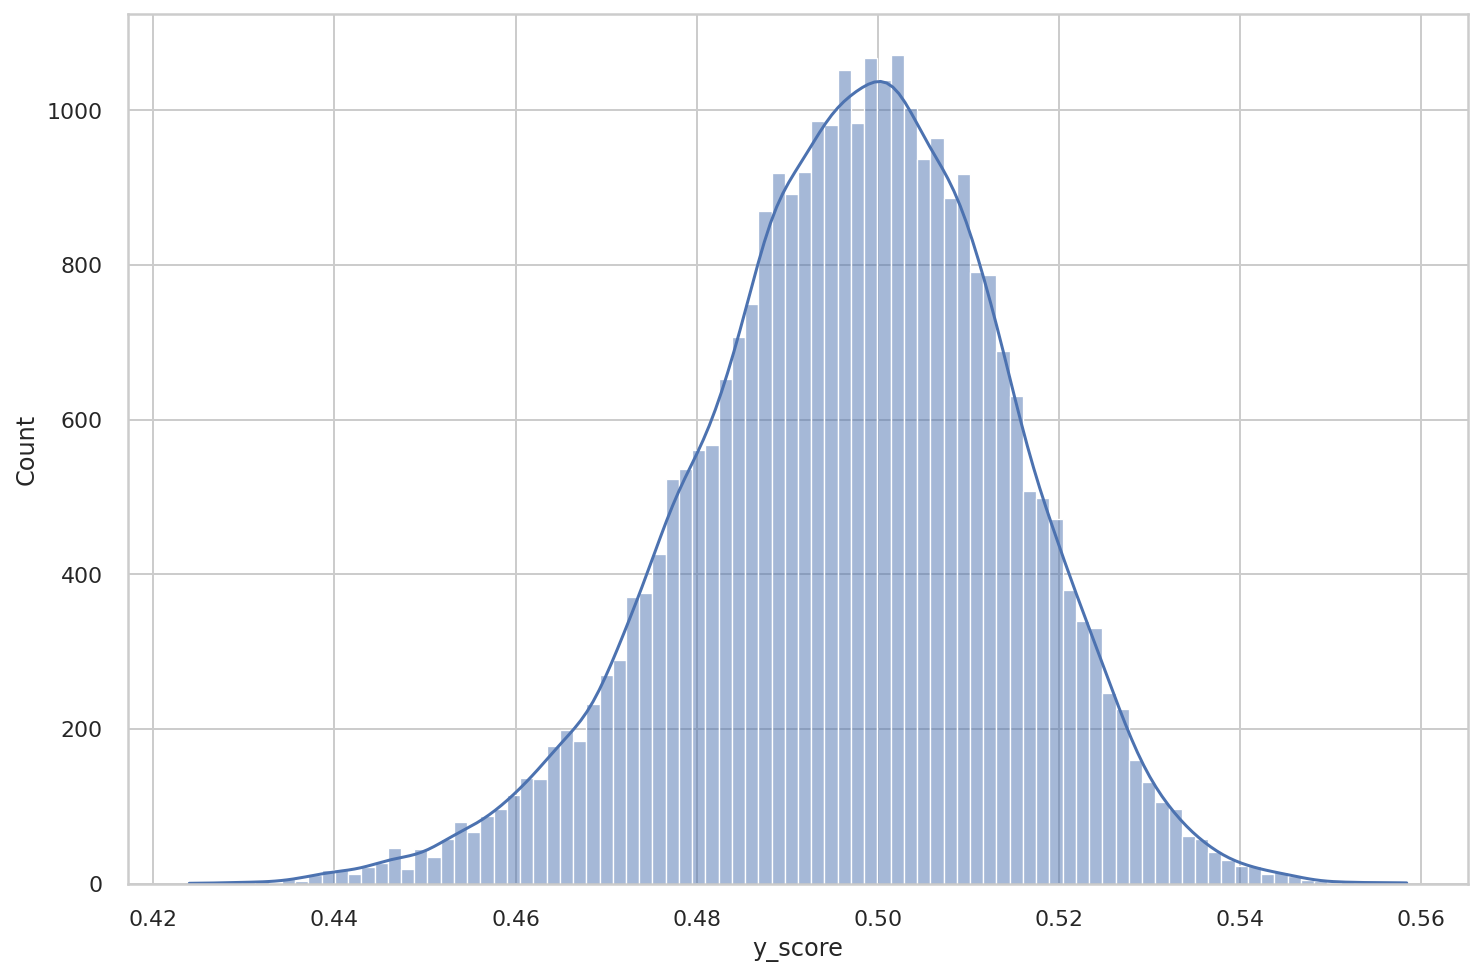

In [33]:
sns.histplot(result['y_score'], kde=True);

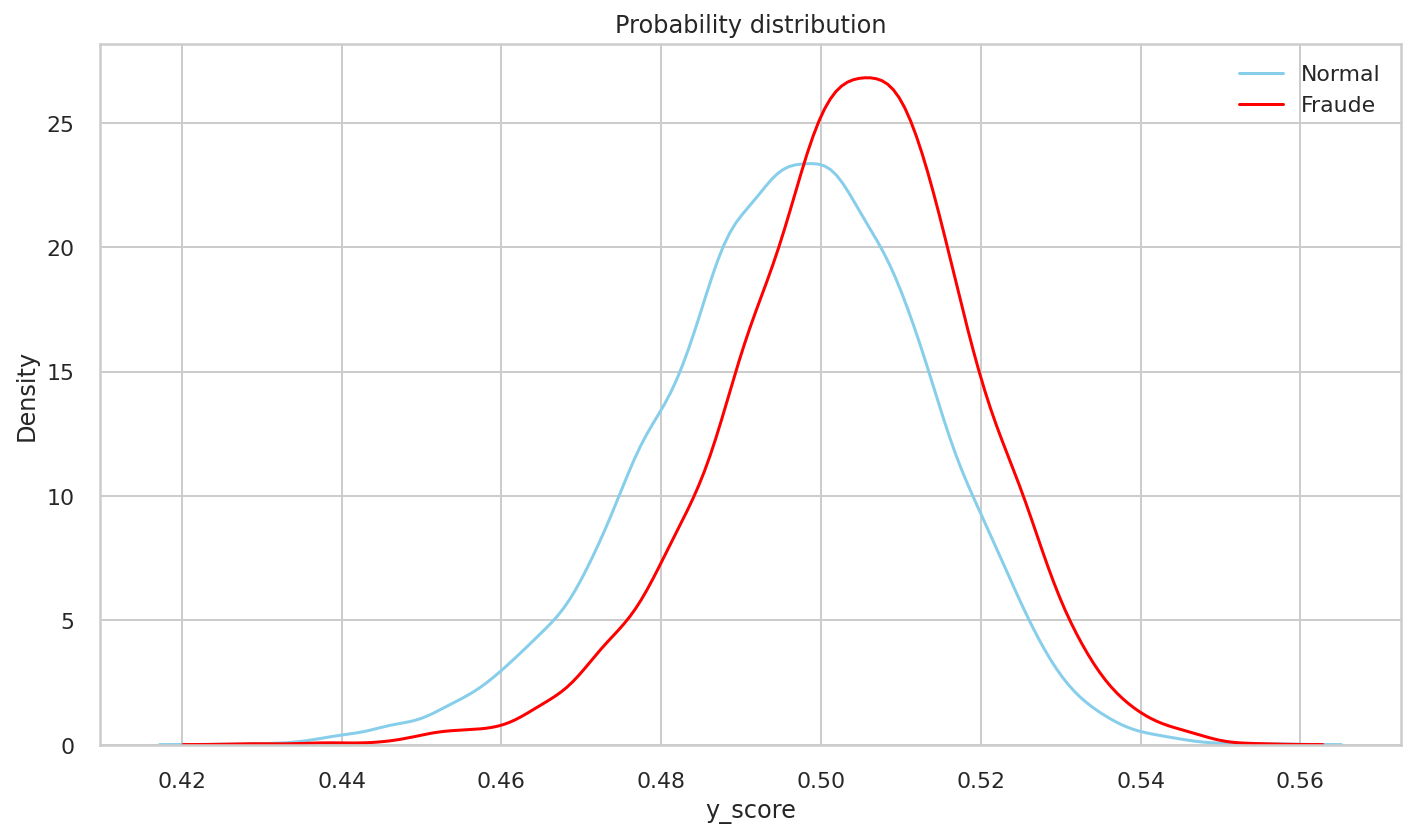

In [34]:
def plot_dist_probs(df_result):
    """
    plot the dist plot between the classes
    :df_result: a df containing a y_test (target), y_pred and y_prob
    """
    
    plt.figure(figsize=(10,6))
    sns.kdeplot(df_result.loc[df_result['y_test'] == 0, "y_score"] , color="skyblue", label="Normal")
    sns.kdeplot(df_result.loc[df_result['y_test'] == 1, "y_score"] , color="red", label="Fraude")
    plt.legend()
    plt.title("Probability distribution")
    plt.tight_layout()
    
plot_dist_probs(result)

### Learning Curve

In [35]:
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve

In [36]:
X_res = pd.concat([X_train, X_test])
y_res = pd.concat([y_train, y_test])

/home/jrcunha/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


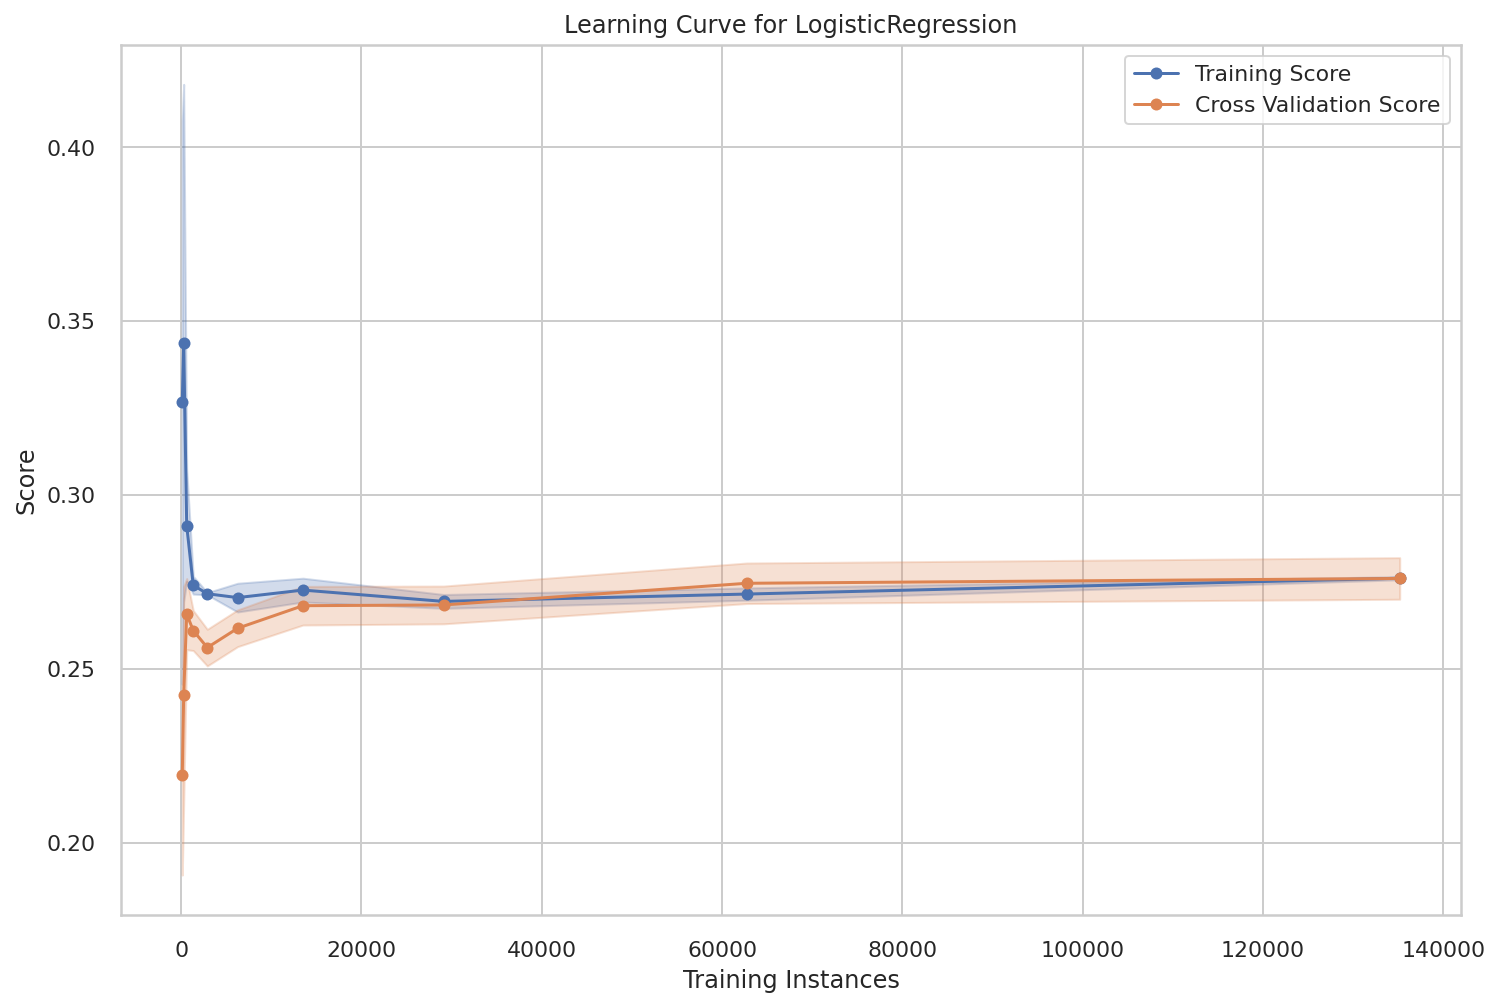

In [37]:
seed = 142
params = {'C': 1e-4, 
          'class_weight': 'balanced',
          'max_iter': 1000,
          'multi_class': 'auto',
          'n_jobs': -1,
          'penalty': 'l2', 
          'random_state': seed,
          'solver': 'lbfgs'} 

lr_model = LogisticRegression(**params)

cv = StratifiedKFold(n_splits=10)
sizes = np.logspace(-3, 0, 10)

visualizer = LearningCurve(
    lr_model, cv=cv, scoring='f1', train_sizes=sizes, n_jobs=-1
)

visualizer.fit(X_res, y_res)        # Fit the data to the visualizer
visualizer.show();           # Finalize and render the figure

### grid search

In [38]:
lr_model.get_params()

{'C': 0.0001,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': 142,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [39]:
param_grid = {'C': np.logspace(-3,3, 20),
              'class_weight': ['balanced'],
              'max_iter': [500],
              'n_jobs': [-1],
              'penalty': ['l2'],
              'random_state': [142],
              'solver': ['lbfgs']}

estimator = LogisticRegression()

clf = GridSearchCV(estimator,
                   param_grid=param_grid,
                   scoring='f1',
                   n_jobs=-1,
                   cv=3,
                   verbose=0,
                   return_train_score=False)

clf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03]),
                         'class_weight': ['balanced'], 'max_iter': [500],
                         'n_jobs': [-1], 'penalty': ['l2'],
                         'random_state': [142], 'solver': ['lbfgs']},
             scoring='f1')

In [40]:
clf.best_estimator_.get_params()

{'C': 0.3359818286283781,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'auto',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': 142,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [41]:
clf.best_score_

0.29137783939708256